# Chapter 5: Using Inequality Indices to Measure Algorithmic Unfairness

Inequality indices are used extensively in economics and social development to measure inequality in metrics across individuals and groups in a population. Indices such as the coefficient of variation, Gini and Theil are, for example, used widely to measure income inequality.

Inequality indices essentially measure how unevenly distributed some quantity is, the most 'even' distribution being uniform. Other applications outside of wealth inequality include measuring racial segregation and the efficiency of distributed systems (e.g. software, irrigation).

In this notebook we investigate the use of inequality indices for measuring how unfairly the benefits of a classification algorithm are distributed. The technique is described in:

[A Unified Approach to Quantifying Algorithmic Unfairness: Measuring Individual & Group Unfairness via Inequality Indices, Till Speicher, Hoda Heidari, Nina Grgic-Hlaca, Krishna P. Gummadi, Adish Singla, Adrian Weller, Muhammad Bilal Zafar, KDD 2018.](http://mlg.eng.cam.ac.uk/adrian/KDD2018_inequality_indices.pdf)

## Import libraries

In [1]:
import sys

import os.path
from os import path

import requests

import math
#import random
import numpy as np
from numpy import ma
#import pandas as pd
import scipy.stats as ss

#from aif360.datasets import StructuredDataset
#from aif360.datasets import BinaryLabelDataset
#from aif360.metrics import BinaryLabelDatasetMetric
#from aif360.metrics import ClassificationMetric

#from sklearn.metrics import f1_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import recall_score
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import make_scorer
#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import GradientBoostingClassifier

#!{sys.executable} -m pip install xgboost
#!brew install libomp
#import xgboost as xgb
#from xgboost import XGBClassifier

#!{sys.executable} -m pip install seaborn
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from mpl_toolkits.mplot3d import Axes3D  

%matplotlib inline

plt.rcParams.update({"text.usetex": True})
print('matplotlib version {}'.format(matplotlib.__version__))

matplotlib version 3.0.3


## 1. Generalised entropy indices (GEI) $I_{\alpha}(\mathbf{b})$

For benefits $\mathbf{b}=(b_1, b_2,...,b_n)$ with mean benefit $\mu$ and $\alpha=0$,
$$
I_0(\mathbf{b}) = -\frac{1}{n}\sum_{i=1}^{n} \ln \frac{b_i}{\mu}.
$$
For $\alpha=1$ (a.k.a. Theil index),
$$
I_1(\mathbf{b}) = T(\mathbf{b}) = \frac{1}{n}\sum_{i=1}^{n} \frac{b_i}{\mu} \ln \frac{b_i}{\mu}.
$$
For constant real valued $\alpha \notin \{0,1\}$, the generalised entropy index  is given by:
$$
I_{\alpha}(\mathbf{b}) = \frac{1}{n\alpha(\alpha-1)} \sum_{i=1}^n\left[ \left(\frac{b_i}{\mu}\right)^{\alpha}-1 \right].
$$
 
#### Notes:

-  The constant $\alpha$ can be thought of as a weight that determines the strength of the contribution to the index from different parts of the benefit distribution.
- For $\alpha\leq0$ the index is unbounded above and only defined where all benefits are greater than zero, making it unsuitable for measuring inequality where this is not the case.

### 1.1 Properties

- **Anonymity:** The measure depends only on the benefits. No other characteristics of the individuals in the group are relevant and it does not matter who earned each benefit.
- **Population invariance** The measure does not depend on the size of the population. More specifically, the value of the inequality measure does not change if we increase the population under consideration by replicating it $k$ times. 
- **Scale invariance** The measure does not change under a constant scaling of the benefits.
- Generalised entropy indices are the only differentiable family of inequality indices which satisfy both population and scale invariance.
- **Transfer principle** Transferring benefit from a high benefit individual to a low benefit individual must decrease the value of the measure, provided the amount of benefit transferred does not exceed the amount required for the individuals to switch places in their benefit ranking.
- **Zero-normalisation** The measure achieves the minimal value of zero when all individuals receive the same (positive and non-zero) benefit.
- **Subgroup decomposability** For any partition of the population into (mutually exclusive) subgroups, the index can be written as the sum of a
  - **between-group component** calculated as the value of the index where all individuals are assigned the mean benefit of their subgroup, and a
  - **within-group component** calculated as a weighted sum of the index values for the subgroups.

#### Notes:

- The anonymity property is a significant departure from the notion of individual fairness described by Dwork - that similar people be treated similarly. For Dwork, similarlity of individuals is based on much more information, potentially all of it.


### 1.2 Benefit functions (mapping from outcome to benefit) described in the paper

![](figures_in/04_BenefitFunctionsTbl.png)

#### Notes:

- In all cases the benefit functions have cases where the benefit can be zero, thus restricting us to $\alpha>0$.
- All but one of the benefit functions described in this table result in binary benefit arrays.
- **Observation:**
  - We can choose to partition our population by the target variable.
  - In this case the value for the index for each group will be zero, since everyone in each group has the same benefit. That said, if we allow zero benefits one of the groups, has a total benefit of zero which results in zero mean. This makes me think it doesn't make sense to allow zero valued benefits.
  - If we don't have zero benefits, the value of the index must then be exactly equal to the between group component where the groups are determined by the target value.
____

**Questions:**
- Is annonymity a desirable property for a fairness metric? Here, we don't just assume that the data is fair, we assume that everything we need to know about the fairness of an algorithm, is described in one variable - the target. A big assumption here, seems to be that everything you need to know about how fair a model is can be seen by comparing $\hat{y}_i$ with $y_i$.
- Is this choice of benefit function $b_i\in\{0,1,2\}$ a good one?
- Is limiting ourselves to $\alpha>0$ a good idea?
- How should one go about choosing an appropriate value of $\alpha$?
- Different models on the same data set will result in a different total benefit over the population. Does it make sense to compare across models? What if can make the algorithm fairer just by accepting (or rejecting) more people?
- For the benefit functions that simply ignore individuals (map them to n/a in the table above) even the size of the population under consideration can change across models.
- Can we just think of it as a measure of how uniformly distributed the the benefits of an algorithm are?
____

### 1.3 Implement GEI

In [2]:
def gei(b, alpha=2):
    """
    return the value of the generalised entropy index
    given a list of benefits b and parameter alpha
    """

    if any([bi<0 for bi in b]):
        print('gei error: all benefits must be >=0')
    n = len(b)
    mu = sum(b)/n
    
    if alpha==0:
        gei_max = 'no maximum value'
        if any([bi==0 for bi in b]):
            print('gei error: all benefits must be >0 for alpha=0')
        gei = -sum([math.log(bi/mu) for bi in b]) / n
    elif alpha==1:
        gei_max = math.log(n)
        gei = sum([0 if bi==0 else bi*math.log(bi/mu)/mu for bi in b]) / n
    else:
        gei_max = (n**(alpha-1)-1)/(alpha*(alpha-1))
        gei = sum([(bi/mu)**alpha - 1 for bi in b]) / (n*alpha*(alpha-1))
    
    #print('gei_max = ', gei_max)
    return gei
    
print('gei = ',gei([1,1,1,1], 1))

gei =  0.0


**Tests:** Generalized entropy indices are both scale and population invariant

In [3]:
alphas = [0,0.5,1,2]
for a in alphas:
    print('\nalpha = ' , a)
    print(gei([1,2]    , a))
    print(gei([10,20]  , a))
    print(gei([1,2,1,2], a))

alphas = [1,2]
for a in alphas:
    print('\nalpha = ' , a)
    print(gei([1,0]    , a))
    print(gei([10,0]   , a))
    print(gei([1,0,1,0], a))


alpha =  0
0.0588915178281918
0.0588915178281918
0.05889151782819178

alpha =  0.5
0.05760576138604501
0.05760576138604501
0.05760576138604501

alpha =  1
0.056633012265132426
0.056633012265132426
0.056633012265132426

alpha =  2
0.055555555555555525
0.055555555555555525
0.055555555555555525

alpha =  1
0.6931471805599453
0.6931471805599453
0.6931471805599453

alpha =  2
0.5
0.5
0.5


### 1.4 Entropy as a special case

- Entropy measures divergence from the uniform distribution
$$
\textrm{entropy}(\mathbf{p},n) = - \sum_{i=1}^n p_i\ln(p_i).
$$
- Another way to look at entropy is as a measure of uncertainty. The most uncertain one can be is under a the uniform distribution which assigns every outcome the same probability. The least uncertain least uncertain distribution is one where one outcome occurs with probability 1 and all others have zero probability.
- For a uniform distribution with $n$ possible events, each event occurs with probability of $\frac{1}{n}$, in which case entropy has a maximal value of
$$
\max\{\mathrm{entropy}(n)\} = \ln(n).
$$
- Notice that here we are only interested in the probability distribution, not the outcome itself. The probabilities over all events should sum to 1.
- This is basically the Theil index.

### 1.5 Back to GEI

- Given an array of benefits we can calculate what proportion of the total benefit each individual received by dividing their benefit by the sum of the benefits in the array.
- If the benefits are equally divided among the population, each individual receives the mean benefit.
$$
B = \sum_{i=1}^n b_i \quad\textrm{and}\quad \mu = \frac{B}{n}
$$
- If we divide the benefits by the mean benefit (instead of the sum), we calculate how many times the 'fair' amount each individual received.
- Notice that the index can be written as,
$$
I_{\alpha}(\mathbf{b}) = \mathbb{E}\left[f_{\alpha}\left(\frac{b}{\mu}\right)\right].
$$

## 2. Contribution from individual $i$ to the index as a function of $b_i$ for varying $\alpha$

We want to visualise the behaviour of the index for varying $\alpha$ in order to be able to make an educated choice for it. We start by looking at the contribution to the index from individuals as a function of $x_i=b_i/\mu$.

The generalised entropy index can be written as
$$
I_{\alpha} = \frac{1}{n}\sum_{i=1}^n f_{\alpha}(x_i) \quad\textrm{where}\quad x_i = \frac{b_i}{\mu}
$$
where $x_i$ is how many times the 'fair' (mean) benefit individual $i$ recieved. To understand the effect of $\alpha$ we plot the function $f_{\alpha}(x)$ for different values of $\alpha$.

$$
f_{\alpha}(x) = \left\{
\begin{array}{ll}
-\ln x & \quad\textrm{for}\quad \alpha=0 \\
x\ln x & \quad\textrm{for}\quad \alpha=1 \\
\dfrac{x^{\alpha}-1}{\alpha(\alpha-1)}
       & \quad\textrm{for}\quad \alpha\in\mathbb{R},\,\alpha\notin\{0,1\}.
\end{array}\right.
$$

The maximum benefit an individual can recieve is the total benefit which is $n$ times the mean,
$$
b_{\max} = \sum_{i=1}^n b_i = n\mu \quad\Rightarrow\quad x_{\max} = \frac{b_{\max}}{\mu} = n.
$$
Given $x_{\max}=n$, and $f_{\alpha}(x)=\infty$ is undefined for $\alpha=0$, we plot $f_{\alpha}(x)$ on $x \in (0,n]$, or rather $[x_{\min}, n]$.

### 2.1 Implement $f_{\alpha}(x)$

In [4]:
def fx_alpha(x, alpha):
    if alpha==0:
        if x==0:
            print('gei error: $x=b/mu$ must be >0 for alpha=0')
        else:    
            return -math.log(x)
    elif alpha==1:
        if x==0:
            return 0
        else:    
            return x*math.log(x)
    else:
        return (x**alpha - 1)/(alpha*(alpha-1))

In [5]:
def compare_lines(xs, lines, x_label, y_label, leg_labels,
                  legend=True, leg_loc=None, multix=False, xaxis=False, yval=0, ylim=None,
                  title=None, filename=None):
    """
    Plot training and test values as a function of x.
    """
    if len(lines)!=len(leg_labels):
        print('lines and leg_labels should have the same dimensions')
    plt.rcParams.update({'font.size': 16})
    plt.figure()
    if title:
        plt.title(title)
    if multix:
        for x, line, label in zip(xs, lines, leg_labels):
            plt.plot(x, line, lw=2, label = label)
    else:
        for line, label in zip(lines, leg_labels):
            plt.plot(xs, line, lw=2, label = label)
    if legend:
        if leg_loc:
            plt.legend(loc=leg_loc)
        else:
            plt.legend()
    if ylim:
        plt.ylim(ylim[0],ylim[1])
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if xaxis:
        plt.axhline(y = yval, color='black', linewidth = 0.75)
    plt.tight_layout()
    if filename:
        plt.savefig('05_figures_out/Fig_'+filename+'.png', dpi=300)
    plt.show()

### 2.2 Plot $f_{\alpha}(x)$

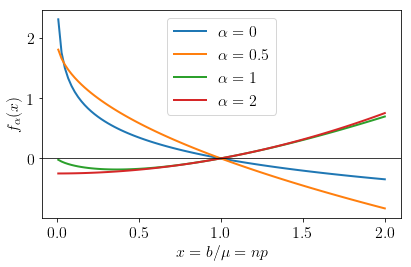

In [51]:
xmin = 0.01
n = 2
npts = 100
dx = (n-xmin)/(npts-1)
x = [xmin+i*dx for i in range(npts)]
alphas = [0,0.5,1,2]
leg_labels = [r'$\alpha='+str(a)+'$' for a in alphas]
lines = []
for a in alphas:
    y = [fx_alpha(xi, a)/n for xi in x]
    lines.append(y)

compare_lines(x, lines=lines, x_label = r'$x=b/\mu=np$', y_label = r'$f_{\alpha}(x)$',
              leg_labels=leg_labels, xaxis=True, filename='fxvaralpha')

#### Notes:

- The contribution to the index from individuals receiving the mean benefit is always zero, i.e. $f_{\alpha}(x=1)\,\forall\alpha$
- The value of the index is always positive but the contribution from any given individual need not be.
- The index is population invariant so $f_{\alpha}(x)$ can't be - it must decrease like $1/n$.
- $f_{\alpha}(x)\rightarrow\infty$ as $x\rightarrow 0$ for $\alpha\leq0$

### 2.3 Functional analysis $f_{\alpha}(x)$

Let's check these functions look like we expect them to...

____

### $\alpha=0$:

$$
f_0(x) = -\ln (x) \quad\Rightarrow\quad
f'_0(x) = -\frac{1}{x} < 0 \quad\textrm{for}\quad x\in(0,n).
$$
$f_0(x)$ is a strictly decreasing.
$$
f'_0(x):(0,n)\rightarrow\left(-\infty,-\frac{1}{n}\right).
$$
$f_0(x)=0 \quad\Leftrightarrow\quad x=1 \quad$ and $\quad f_0(x)<0 \quad$ for $\quad x>1$.

____

### $\alpha=1$:

$$
f_1(x) = x\ln(x) \quad\Rightarrow\quad 
f'_1(x) = 1 + \ln(x) = 0 \quad\Leftrightarrow\quad x = \frac{1}{e}.\\
f''_1(x) = \frac{1}{x} > 0 \quad\forall\,x > 0 \quad\Rightarrow\quad x=\frac{1}{e}\textrm{ is a minimum}
\quad\Rightarrow\quad\left\{
\begin{array}{c}
x < \frac{1}{e} \quad\Rightarrow\quad f_1 \quad\textrm{decreasing} \\
x > \frac{1}{e} \quad\Rightarrow\quad f_1 \quad\textrm{increasing}.
\end{array}
\right.
$$
$f_1(0)=f_1(1)=0\quad$ and $\quad f_1(x)<0\quad$ for $\quad x<1$.

____

### $\alpha \notin \{0,1\}$:

$$
f_{\alpha}(x) = \frac{x^{\alpha}-1}{\alpha(\alpha-1)} \quad\Rightarrow\quad
f'_{\alpha}(x) = \frac{x^{\alpha-1}}{\alpha-1} > 0 \quad\forall\quad x>0.\\
$$
$f'_{\alpha}(x)=0\quad\Leftrightarrow\quad x=0 \quad\Rightarrow\quad f_{\alpha}(x)$ is strictly increasing.
$$
f_{\alpha}(x):[0,n]\rightarrow\left[\frac{-1}{\alpha(\alpha-1)}, \frac{n^{\alpha}-1}{\alpha(\alpha-1)}\right]. \\
\begin{align}
\alpha<1 \quad\Rightarrow\quad &
f'_{\alpha}(x):(0,n]\rightarrow\left(-\infty, \frac{-1}{(1-\alpha)n^{1-\alpha}}\right] &\quad\textrm{the gradient is decreasing} \\
\alpha>1 \quad\Rightarrow\quad &
f'_{\alpha}(x):(0,n]\rightarrow\left(0, \frac{n^{\alpha-1}}{\alpha-1}\right] &\quad\textrm{the gradient is increasing}
\end{align}
$$

____

#### Summary

- For $\alpha<1$, $f_{\alpha}(x)$ is a strictly decreasing
- For $\alpha=1$, $f_{\alpha}(x)$ is minimal at $x=e^{-1}$
- For $\alpha>1$, $f_{\alpha}(x)$ is a strictly increasing

## 3. Behaviour of generalised entropy indices for two benefit levels $b_{\min}$ and $b_{\max}$

- Start with $b_i=b_{\max}$ for $i\in\{1, 2,..., n\}$. Here the index value is zero. Look at how the index behaves as we increase the number of individuals with benefit $b_{\min}$.
- In doing this we are running through all possible distributions of $\boldsymbol{b}$ (under the two benefit values restriction).
- We change the distribution of benefits by increasing the proportion of people receiving benefit $b_{\min}$.

In [47]:
def compare_indices(bmin, bmax, n, notitle=False):
    if bmax<=bmin:
        print('Error: bmax must be larger than bmin')
    b    = [bmin]*n
    mu   = [bmin+(bmax-bmin)*i/n for i in range(1,n+1)]
    gei0 = [0]*n
    thi1 = [0]*n
    gei2 = [0]*n
    for i in range(n):
        b[i] = bmax
        gei2[i] = gei(b, 2)
        thi1[i] = gei(b, 1)
        if bmin>0:
            gei0[i] = gei(b, 0)
        else:
            gei0[i] = gei(b, 0.5)
    if bmin>0:
        lines = [gei0, thi1, gei2]
        leg_labels=[r'$\alpha=0$',r'$\alpha=1$',r'$\alpha=2$']
    else:
        lines=[gei0, thi1, gei2]
        leg_labels=[r'$\alpha=1/2$',r'$\alpha=1$',r'$\alpha=2$']
        
    if notitle:
        compare_lines(mu, lines=lines,
                      x_label=r'Mean benefit $\mu$',
                      y_label=r'Index value $I_{\alpha}(\mu)$', leg_labels=leg_labels,
                      filename='GEI_bmin'+str(bmin)+'_n'+str(n))
    else:
        compare_lines(mu, lines=lines,
                      x_label=r'Mean benefit $\mu$',
                      y_label=r'Index value $I_{\alpha}(\mu)$', leg_labels=leg_labels,
                      title=r'Binary Benefits $(n='+str(n)+')$',
                      filename='GEI_bmin'+str(bmin)+'_n'+str(n))

### 3.1 Binary benefits: $b_{\min}=0$

- $b_i\in\{0,1\}$, 

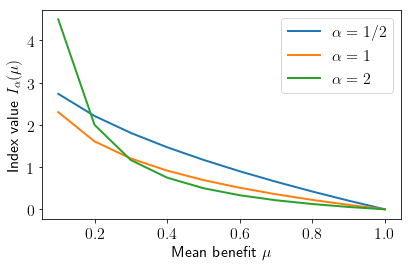

In [48]:
compare_indices(0, 1, 10, True)

#### Notes:

- For $\alpha>0$, the value of the index is bounded above. It has maximal value (over all possible benefit distributions $\boldsymbol{b}$) when only a single individual recieves all the benefits.

### 3.2 $\max_{\boldsymbol{b}}[I_{\alpha}(\boldsymbol{b};n)]$ for $\alpha>0$

The maximal value of the index is a function of $n$:

$$
\max_{\boldsymbol{b}}[I_{\alpha}(\boldsymbol{b};n)] = \left\{
\begin{array}{ll}
\ln n & \quad\textrm{for}\quad\alpha=1 \\
\dfrac{n^{\alpha-1}-1}{\alpha(\alpha-1)}
      & \quad\textrm{for}\quad0<\alpha\ne1
\end{array}\right.
$$

#### Notes:

- The larger $n$ is, the more unfair assigning all the benefit to a single individual is.
- If 'overall unfairness' is capped, then so is between-group unfairness.

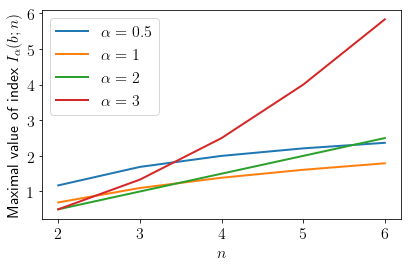

In [43]:
def I_max(n, alpha):
    if alpha<0:
        print('Index is unbounded')
    if alpha==1:
        return math.log(n)
    else:
        return (n**(alpha-1)-1)/(alpha*(alpha-1))
    return -1

nmin = 2
nmax = 6
ns = [n for n in range(nmin,nmax+1)]

alphas = [0.5,1,2,3]
leg_labels=[r'$\alpha='+str(a)+'$' for a in alphas]
#lines = [[0]*(nmax-nmin+1)]*len(alphas)
lines = [[I_max(n, a) for n in ns] for a in alphas]

compare_lines(ns, lines=lines, x_label=r'$n$', y_label=r'Maximal value of index $I_{\alpha}(b;n)$', leg_labels=leg_labels,
              filename='GEI_Imaxvaralpha')

In [44]:
# Quick test against my paper calculation for alpha=0.5

ns = [4, 16, 400]
for n in ns:
    print('n = ', n,  ': ? ', I_max(n,0.5), ' = ', 4*(1-1/n**0.5))
    print(math.log(2))

n =  4 : ?  2.0  =  2.0
0.6931471805599453
n =  16 : ?  3.0  =  3.0
0.6931471805599453
n =  400 : ?  3.8  =  3.8
0.6931471805599453


### 3.3 Functional analysis of $\max_{\boldsymbol{b}}[I_{\alpha}(\boldsymbol{b};n)]$
____

For $\alpha=1$, $\max\{I_{\alpha}\}=\ln(n)$. The maximal value grows and $\rightarrow\infty$ at an ever decaying rate (the slope decays like $1/n$).
____

For $\quad \alpha>0, \quad\alpha\ne1$
$$
\max\{I_{\alpha}(n)\} = \frac{n^{\alpha-1}-1}{\alpha(\alpha-1)}
$$
____

For $\quad 0<\alpha<1, \quad \alpha(\alpha-1)<0$
$$
n^{\alpha-1}-1 = \frac{1}{n^{1-\alpha}}-1<0
$$
For $\quad \alpha>1, \quad \alpha(\alpha-1)>0$
$$
n^{\alpha-1}-1 > 0
$$
Confirming that $\quad\max\{I_{\alpha}(n)\}>0\quad\forall\,\alpha$. Phew!

For $\quad 0<\alpha<1$,
$$
\max\{I_{\alpha}(n)\} = \frac{1-n^{-(1-\alpha)}}{\alpha(1-\alpha)}\quad\rightarrow\frac{1}{\alpha(1-\alpha)}
\quad\textrm{as}\quad n\rightarrow\infty.
$$
____

For $\alpha=1/2$, the index has a maximal value of
$$
\max\{I_{\alpha}\} = 4\left(1-\frac{1}{\sqrt{n}}\right) < 4 \quad\forall\, n.
$$
____

#### Questions:

- Does it make sense for a measure of equality/uniformity to be bounded, regardless of the population $n$?
- For a measure of fairness, does it make sense for there to be a limit on how unfair a given scenario might be?
  - Maybe an increasing function of the population $n$ makes sense, but how quickly should it increase?
  - $\alpha=2$ corresponds to the upper bound increasing linearly in proportion to the population. Seems like a reasonable choice?
____

### 3.4 Positive, non-zero benefits: $b_{\min}>0$

- $b_i\in\{1,2\}$

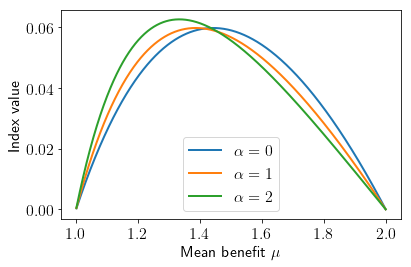

In [45]:
compare_indices(1, 2, 1000, notitle=True)

- $b_i\in\{1,10\}$

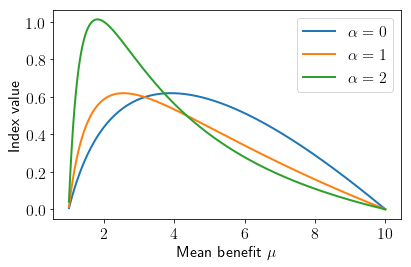

In [46]:
compare_indices(1, 10, 1000, notitle=True)

#### Notes:

- In the case of binary benefits, as we increase the number of individuals who benefit by the same fixed amount, it's clear that we are making the distribution of benefits more uniform. However, when there are two non-zero benefits, running through the possible distributions in this way, no longer corresponds to increasing unfairness.

## 4. $I_{\alpha}(\mathbf{b})$ for varying benefit distributions over $b_i\in\{0, 1, 2\}$

We're interested the behaviour for the suggested benefit function and choice of $\alpha=2$ used in the paper:

[A Unified Approach to Quantifying Algorithmic Unfairness: Measuring Individual & Group Unfairness via Inequality Indices, Till Speicher, Hoda Heidari, Nina Grgic-Hlaca, Krishna P. Gummadi, Adish Singla, Adrian Weller, Muhammad Bilal Zafar, KDD 2018.](http://mlg.eng.cam.ac.uk/adrian/KDD2018_inequality_indices.pdf)

### 4.1 Similarity with cost sensitive learning

- The fairness metric is computed much like a cost sensitive loss function but the cost (or rather 'fairness') matrix depends on two things
  1. The mean distribution of benefits, $\mu$,
  2. Our choice of parameter $\alpha$.
$$
\begin{align}
c_{ij} = \mathrm{cost}(\hat{y}=i, y=j)
& = \left(
\begin{array}{cc}
f_{\alpha}(1/\mu) & f_{\alpha}(0)     \\
f_{\alpha}(2/\mu) & f_{\alpha}(1/\mu)
\end{array}\right)
\end{align}
$$
  
#### Notes:

- Our distribution of benefits is much more constrained than something like income. We cannot arbitrarilty redistribute benefits from rich to poor, the range of benefits an individual can receive is limited based their actual label, $y$,

$$
y=0 \quad\Rightarrow\quad b\in\{0,1\} \\
y=1 \quad\Rightarrow\quad b\in\{1,2\}
$$

- Any reasonable model should have an accuracy of at least 50%. For a given data set / problem, this lower bound increases to

$$
\max[\mathbb{P}(Y=1), 1-\mathbb{P}(Y=1)].
$$

- Assuming an accuracy of 50% (for these individuals $b_i=1$), the remaining benefits will either be false positives or false negatives (for these individuals $b_i=0$ or $b_i=2$).
- The sum of benefits $B$ for any model must then be at least $n/2$ and at most $3n/2$ depending on whether our model accepts all or rejects all individuals.
- Therefore, the mean benefit is constrained

$$
\frac{1}{2}\leq\mu\leq\frac{3}{2} \quad\textrm{and}\quad 0\leq b\leq2
\quad\Rightarrow\quad 0 < x = \frac{b}{\mu} < 4
$$

- We see that for any reasonable model, the maximum contribution to the index from any given individual will be $\mathrm{O}(1/n)$.
- In short, our distribution of benefits for any 'reasonable' binary classification model, are much more uniform than something like income.

Let's take a look at the behaviour of $f_{\alpha}(x)$ again.

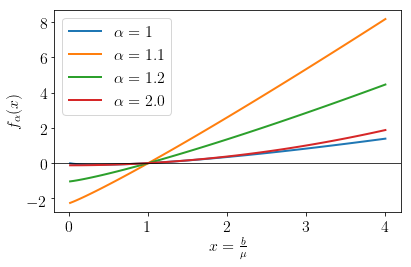

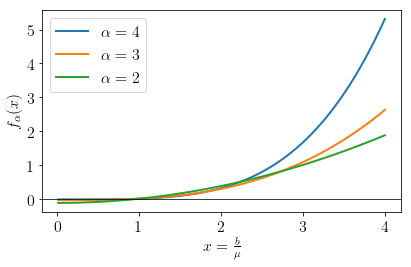

In [32]:
xmin = 0.01
n = 4
npts = 100
dx = (n-xmin)/(npts-1)
x = [xmin+i*dx for i in range(npts)]
alphas = [1,1.1,1.2,2.0]
leg_labels = [r'$\alpha='+str(a)+'$' for a in alphas]
lines = []
for a in alphas:
    y = [fx_alpha(xi, a)/n for xi in x]
    lines.append(y)

compare_lines(x, lines=lines, x_label = r'$x=\frac{b}{\mu}$', y_label = r'$f_{\alpha}(x)$', leg_labels=leg_labels,
              xaxis=True, filename='fxvaralpha2minus')

alphas = [4,3,2]
leg_labels = [r'$\alpha='+str(a)+'$' for a in alphas]
lines = []
for a in alphas:
    y = [fx_alpha(xi, a)/n for xi in x]
    lines.append(y)

compare_lines(x, lines=lines, x_label = r'$x=\frac{b}{\mu}$', y_label = r'$f_{\alpha}(x)$', leg_labels=leg_labels,
              xaxis=True, filename='fxvaralpha2plus')

#### Notes:

- In this range we can more clearly see the differing pattern of behaviour for $1<\alpha\leq2$ versus $\alpha>2$.
- $f_{\alpha}(x)$ is flattest for $\alpha=2$

### 4.2 Parameterise the benefit distribution with model accuracy $\lambda$ and mean $\mu$ benefit

#### Setup

Denote,
- $n_c=$ The number of examples the model gets correct
- $n_+=$ The number of false positives
- $n_-=$ The number of false negatives

The value of the index is given by,
$$
I_{\alpha}(\mathbf{b}) = \frac{1}{n}\left[ n_- f_{\alpha}(0) + n_c f_{\alpha}\left(\frac{1}{\mu}\right)
                                                             + n_+ f_{\alpha}\left(\frac{2}{\mu}\right) \right].
$$

Note that

$$
n_- = n-n_c-n_+ \quad\textrm{and}\quad \mu = \frac{n_c+2n_+}{n} \quad\textrm{and}\quad \lambda = \frac{n_c}{n}
$$

We can write the value of the index in terms of the model accuracy ($n_c/n$) and mean benefit ($\mu$),

$$
I_{\alpha}\left(\lambda,\mu\right) = \left\{
\begin{array}{ll}
\left(1-\dfrac{\lambda}{\mu}\right)\ln2-\ln\mu
& \quad\textrm{for}\quad\alpha = 1 \\
\dfrac{1}{\alpha(\alpha-1)\mu^{\alpha}}
\left[ 2^{\alpha-1}\mu - (2^{\alpha-1}-1)\lambda - 1 \right]
& \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right.
$$

Note that, for fixed $\mu$, $I_{\alpha}(n_c/n,\mu)$ is a linearly decreasing function of accuracy for all $\alpha>0$. For most problems, the accuracy of our model is bounded below by our dataset,
$$
0.5 \leq \max[\mathbb{P}(Y=0), \mathbb{P}(Y=1)] < \lambda \leq 1.
$$
If we can find the maximal value of the index for a given accuracy, this allows us to find an upper bound for the index, based on a dataset with known $\Prob(Y=1)$. Before analysing the behaviour of the index as a function of $\mu$, we note that $\mu$ is also constrained for our classifier. For a model with accuracy $\lambda=n_c/n$, the total number of benefits $B$, must satisfy the following bounds
$$
n_c \leq B \leq n_c+2(n-n_c) = 2n-n_c.
$$
We know also that the total number of benefits must equate to $n$ times the mean, that is, $B=n\mu$. Given this, it is straightforward to show that we must have
$$
\lambda \leq \mu \leq 2 - \lambda.
$$
As $\lambda$ increases, the range of possible values $\mu$ can take decreases. The index is defined on a triangular domain for fixed $\alpha$.

#### Plot the surface $I_{\alpha}\left(\lambda,\mu\right)$ for fixed $\alpha$

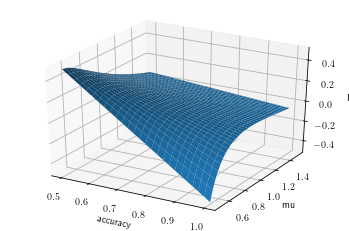

In [53]:
def I_alpha(acc, mu, alpha):
    if alpha==1:
        return (1 - acc/mu)*np.log(2) - np.log(mu)
    else:
        return ((2/mu)**(alpha-1) - (2**(alpha-1)-1)*acc/(mu**alpha) - 1)/(alpha*(alpha-1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Make data.
acc, mu = np.meshgrid(np.linspace(0.5, 1.0, 51), np.linspace(0.5, 1.5, 101))
I = I_alpha(acc, mu, 2)
I = ma.masked_where(mu<acc, I)
I = ma.masked_where(mu>2-acc, I)

ax.plot_surface(acc, mu, I)

ax.set_xlabel('accuracy')
ax.set_ylabel('mu')
ax.set_zlabel('I')

plt.show()

#### Note

- The mask is being ignored -  bug in this version of matplotlibs plot_surface. Need [https://stackoverflow.com/questions/24577248/how-to-make-a-3d-matlibplot-not-show-masked-values](matplotlib version 3.5.X).
- What I need is a contour plot

#### Plot the domain $I_{\alpha}\left(\lambda,\mu\right)$ for fixed $\alpha$

In [ ]:
def plot_domain()
    plt.rcParams.update({'font.size': 16})
    plt.figure()
    plt.title('Index domain')
    if multix:
        for x, line, label in zip(xs, lines, leg_labels):
            plt.plot(x, line, lw=2, label = label)
    else:
        for line, label in zip(lines, leg_labels):
            plt.plot(xs, line, lw=2, label = label)
    if legend:
        if leg_loc:
            plt.legend(loc=leg_loc)
        else:
            plt.legend()
    if ylim:
        plt.ylim(ylim[0],ylim[1])
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if xaxis:
        plt.axhline(y = yval, color='black', linewidth = 0.75)
    plt.tight_layout()
    if filename:
        plt.savefig('05_figures_out/Fig_'+filename+'.png', dpi=300)
    plt.show()

### 4.3 Find maximum for fixed 

#### Find turning points of $I_{\alpha}\left(n_c/n,\mu\right)$ for fixed $n_c/n$

$$
\begin{gather*}
\frac{\partial I_{\alpha}}{\partial \mu} = \left\{
\begin{array}{ll}
\dfrac{1}{\mu^2} \left( \dfrac{n_c}{n}\ln2 - \mu \right)
& \quad\textrm{for}\quad\alpha = 1 \\
\dfrac{1}{\alpha(\alpha-1)\mu^{\alpha+1}}
\left[ \alpha(2^{\alpha-1}-1)\dfrac{n_c}{n} - (\alpha-1)2^{\alpha-1}\mu \right]
& \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right. \\
%
\frac{\partial I_{\alpha}}{\partial \mu} = 0 \quad\Leftrightarrow\quad
\mu = \mu_* = \dfrac{n_c}{n}g(\alpha) \quad\textrm{where}\quad
g(\alpha) = \left\{
\begin{array}{ll}
\ln2 & \quad\textrm{for}\quad\alpha = 1 \\
\dfrac{\alpha(2^{\alpha-1}-1)}{(\alpha-1)2^{\alpha-1}}
& \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right. \\
%
\frac{\partial^2 I_{\alpha}}{\partial \mu^2} =\left\{
\begin{array}{ll}
\dfrac{1}{\mu^3} \left[\mu-\dfrac{n_c}{n}2\ln2\right]
& \quad\textrm{for}\quad\alpha = 1 \\
\dfrac{2^{\alpha-1}}{\mu^{\alpha+2}}
\left[\mu-\dfrac{(\alpha+1)(2^{\alpha-1}-1)}{(\alpha-1)2^{\alpha-1}}
      \dfrac{n_c}{n}\right] & \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right.\\
%
\Rightarrow\quad\left.\frac{\partial^2 I_{\alpha}}{\partial \mu^2}\right|_{\mu=\mu_*} = \left\{
\begin{array}{ll}
-\dfrac{\ln2}{\mu_*^3} \dfrac{n_c}{n}
& \quad\textrm{for}\quad\alpha = 1 \\
-\dfrac{(2^{\alpha-1}-1)}{\mu_*^{\alpha+2}(\alpha-1)} \dfrac{n_c}{n}
& \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right\}<0 \quad\forall\,\alpha>0.
\end{gather*}
$$

We have shown that the index is maximal at $\mu=\mu_*$ for all $\alpha>0$. To summarise,

$$
\begin{gather}
\max_{\mu}\left[I_{\alpha}\left(\frac{n_c}{n},\mu\right)\right]
= I_{\alpha}\left(\frac{n_c}{n},\mu_*\right) \nonumber\\
\textrm{where}\quad \mu_* = \dfrac{n_c}{n}g(\alpha) \quad\textrm{and}\quad
g(\alpha) = \left\{
\begin{array}{ll}
\ln2 & \quad\textrm{for}\quad\alpha = 1 \\
\dfrac{\alpha(2^{\alpha-1}-1)}{(\alpha-1)2^{\alpha-1}}
& \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right. \label{eq:g_alpha}
\end{gather}
$$

#### Plot $g(\alpha)$ for $\alpha\geq0$

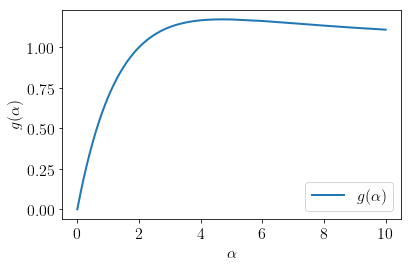

In [15]:
def g_alpha(alpha):
    if alpha==1:
        return math.log(2)
    else:
        return ( (2**(alpha-1)-1)*alpha )/( (alpha-1)*2**(alpha-1) )

alphas = [i/10 for i in range(50)]+[i for i in range(5,11)]
gs = [g_alpha(a) for a in alphas]
compare_lines(alphas, lines=[gs], x_label=r'$\alpha$', y_label=r'$g(\alpha)$', leg_labels=[r'$g(\alpha)$'],
              filename='g_alpha')

#### Functional analysis of $g(\alpha)$

$$
\begin{gather*}
g(\alpha) = \frac{\alpha(2^{\alpha-1}-1)}{(\alpha-1)2^{\alpha-1}} \quad\Rightarrow\quad
g'(\alpha) = \frac{\alpha(\alpha-1)\ln2 - (2^{\alpha-1}-1)}{[(\alpha-1)2^{\alpha-1}]^2} \\
g'(\alpha) = 0 \quad\Leftrightarrow\quad \bar{g}(\alpha) = 2^{\alpha-1}-1 - \alpha(\alpha-1)\ln2 = 0, \quad\alpha\ne1 
\end{gather*}
$$

#### Notes:

- We have one turning point for $g(\alpha)$, $\alpha>1$. That is,  $g'(\alpha^*)=0$ for $4<\alpha^*<5$.
- $g(\alpha)>1$ for $1<\alpha<2$
- $g(\alpha)<1$ for $\alpha>2$

Denote the root of $g'(\alpha)$ with $\alpha_*$ so $\bar{g}(\alpha_*)=0$ where $\alpha_*>1$

$$
g''(\alpha_*) = \frac{2-\alpha_*\ln2}{(\alpha_*-1)2^{\alpha_*-1}} < 0.
$$

- The turning point is a maximum.

#### Notes:

- Consider the functions $2^x-1$ and $x^2$
  - Both are strictly increasing for $x>0$.
  - $2^{x}-1 = x^2$ at $x=0$ and $x=1$.
  - $2^{x}-1$ dominates $x^2$ for large $x$.
- Compare with $2^{\alpha-1}-1$ and $\alpha(\alpha-1)\ln2$
  - $\alpha=1$ corresponds to the first root but the denomiator is also zero here.
  - There must be exactly one root, $\alpha=\alpha_*$
  - Perfect candidate for a Newton-Raphson root finder since $\bar{g}(\alpha)$ is convex around the root and for all $\alpha>\alpha*$.

$$
\begin{align*}
\bar{g}(\alpha) = 2^{\alpha-1}-1 - \alpha(\alpha-1)\ln2 \quad \alpha>1 \\
\bar{g}'(\alpha) = (2^{\alpha-1} - 2\alpha+1)\ln2 \quad \alpha>1 \\
\end{align*}
$$

#### Plot $\bar{g}(\alpha)$ and find the root using Newton-Raphson

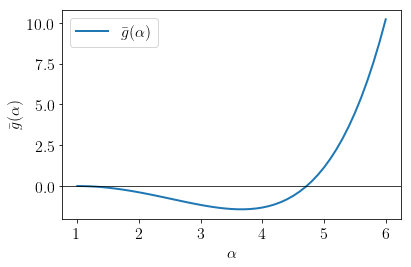

g'(a)=0 then a = 4.7656534838093645 	g(a) =  1.172510068800663
g'(a)=0 then a = 4.7195427505358944 	g(a) =  1.1725302598083718
g'(a)=0 then a = 4.717897206398797 	g(a) =  1.172530284222417
g'(a)=0 then a = 4.717895162966198 	g(a) =  1.1725302842224545
g'(a)=0 then a = 4.717895162963051 	g(a) =  1.1725302842224545
g'(a)=0 then a = 4.717895162963051 	g(a) =  1.1725302842224545
For alpha > 2 and accuracy > 0.9205855561713364 I 


In [16]:
def gbar_alpha(alpha):
    return 2**(alpha-1) - 1 - alpha*(alpha-1)*math.log(2)

def gbardash_alpha(alpha):
    return (2**(alpha-1) - 2*alpha + 1)*math.log(2)

alphas = [1+i/10 for i in range(51)]
gbar = [gbar_alpha(a) for a in alphas]
compare_lines(alphas, lines=[gbar], x_label=r'$\alpha$', y_label=r'$\bar{g}(\alpha)$', leg_labels=[r'$\bar{g}(\alpha)$'],
              xaxis=True)

a0 = 5
for i in range(6):
    a0 = a0 - gbar_alpha(a0)/gbardash_alpha(a0)
    print("g'(a)=0 then a =", a0, '\tg(a) = ', g_alpha(a0))

print('For alpha > 2 and accuracy >', 2.0/(g_alpha(a0)+1), 'I ')

#### Plot $I_{\max}(\alpha)$ and $\tilde{\lambda}(\alpha)$

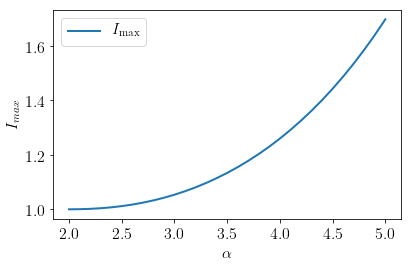

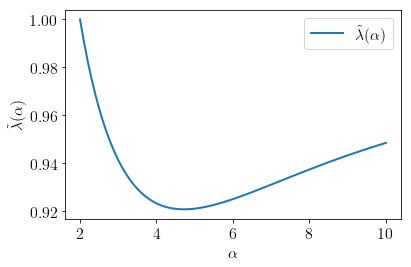

lambda tilde minimum = 0.9205855561713364


In [17]:
def I_c(alpha):
    return 2**(alpha-1)/(alpha*g_alpha(alpha)**(alpha-1))

alphas = [2+i/10 for i in range(31)]
c = [I_c(a) for a in alphas]
compare_lines(alphas, lines=[c], x_label=r'$\alpha$', y_label=r'$I_{max}$', leg_labels=[r'$I_{\max}$'])

def lambda_tilde(alpha):
    return 2.0/(1+g_alpha(alpha))

alphas = [2+i/10 for i in range(81)]
acc = [lambda_tilde(a) for a in alphas]
compare_lines(alphas, lines=[acc], x_label=r'$\alpha$',
              y_label=r'$\tilde{\lambda}(\alpha)$', leg_labels=[r'$\tilde{\lambda}(\alpha)$'],
              filename='lambda_tilde_alpha')

print('lambda tilde minimum =', lambda_tilde(a0))

#### Plot $I_{\alpha}(\lambda,\mu)$ as a function of $\mu$ for varying $\lambda$

g(alpha) = 0.6931471805599453


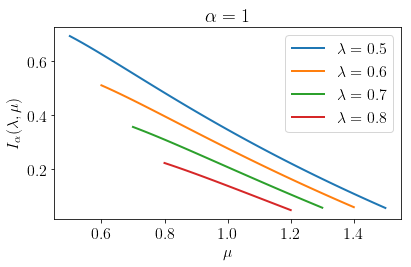

g(alpha) = 1.0


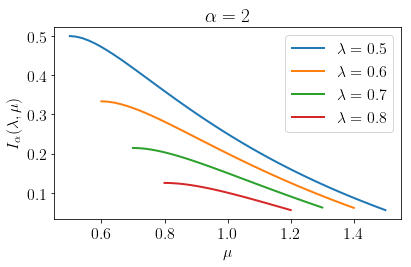

g(alpha) = 1.125
I strictly increasing for lambda > 0.9411764705882353


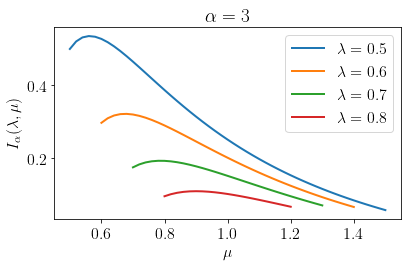

g(alpha) = 1.1666666666666667
I strictly increasing for lambda > 0.9230769230769229


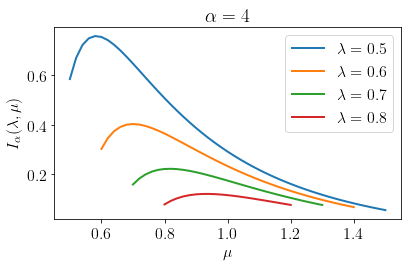

In [18]:
n=100
alphas = [i for i in range(1,5)]
legends = [False]*len(alphas)
legends[0] = True

for j, alpha in enumerate(alphas):
    g = g_alpha(alpha)
    print('g(alpha) =', g)
    lambda_tilde = 2.0/(1+g)
    if alpha>2:
        print('I strictly increasing for lambda >', lambda_tilde)

    ncs = [50, 60, 70, 80]
    mus = [[(nc+2*i)/n for i in range(n-nc+1)] for nc in ncs]
    Is = []
    for nc in ncs:
        b = [0]*(n-nc) + [1]*nc
        I_mu = [gei(b, alpha)]*(n-nc+1)
        for i in range(n-nc):
            b[i] = 2
            I_mu[i+1] = gei(b, alpha)
        Is.append(I_mu)

    compare_lines(mus, lines=Is, x_label=r'$\mu$', y_label=r'$I_{\alpha}(\lambda,\mu)$',#legend=legends[j], 
                  leg_labels=[r'$\lambda='+str(nc/n)+'$' for nc in ncs],
                  multix=True, title=r'$\alpha='+str(alpha)+'$',
                  filename='I_alpha_'+str(alpha)+'_varlambda')

#### Plot $I_{\alpha}(\lambda,\mu)$ as a function of $\mu$ for varying $\alpha$

g(1) = 0.6931471805599453
g(2) = 1.0
g(3) = 1.125
I strictly increasing for lambda > 0.9411764705882353
g(4) = 1.1666666666666667
I strictly increasing for lambda > 0.9230769230769229


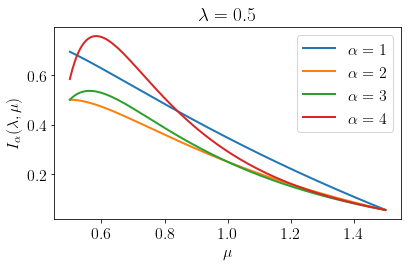

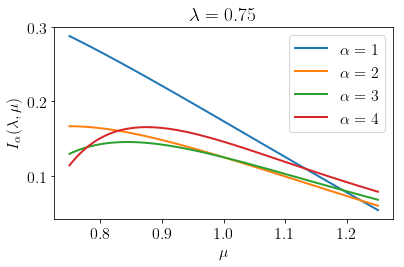

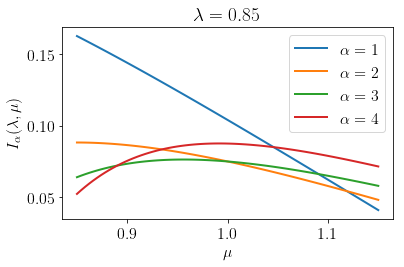

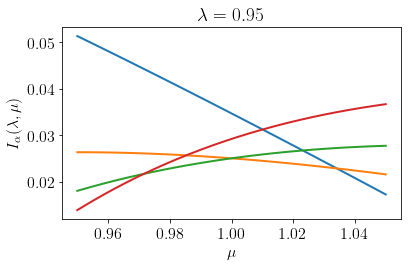

In [19]:
n=500
alphas = [i for i in range(1,5)]
ncs = [5*50, 5*75, 5*85, 5*95]
legends = [True]*len(ncs)
legends[-1] = False

for alpha in alphas:
    g = g_alpha(alpha)
    print('g('+str(alpha)+') =', g)
    if alpha>2:
        print('I strictly increasing for lambda >', 2.0/(1+g))

for j, nc in enumerate(ncs):
    mus = [(nc+2*i)/n for i in range(n-nc+1)]
    Is = []
    for alpha in alphas:
        b = [0]*(n-nc) + [1]*nc
        I_mu = [gei(b, alpha)]*(n-nc+1)
        for i in range(n-nc):
            b[i] = 2
            I_mu[i+1] = gei(b, alpha)
        Is.append(I_mu)

    compare_lines(mus, lines=Is, x_label=r'$\mu$', y_label=r'$I_{\alpha}(\lambda,\mu)$',
                  leg_labels=[r'$\alpha='+str(alpha)+'$' for alpha in alphas], legend=legends[j],
                  title=r'$\lambda='+str(nc/n)+'$',
                  filename='I_lambda_'+str(nc/5)[:-2]+'_varalpha')

### 4.4 Calculate $\Delta I^{\pm}_{\alpha}$

- The smallest change we can have in a model is the prediction on a given datapoint going from
  1. true positive to false negative (or vice versa) or
  2. true negative to false positive
- In particular, for a given distribution of benefits, How does the value of the index change if
  1. We increase the number of false positives by one (and decreased the number of correct predictions by one)
  2. We increase the number of false negatives by one (and decreased the number of correct predictions by one)

$$
\Delta I^{\pm}_{\alpha}(\lambda, \mu; n) = \left\{
\begin{array}{ll}
\left[\left(1\pm\dfrac{\lambda}{\mu}\right)\ln2\mp1\right]\dfrac{1}{n\mu} + \mathrm{O}\left(\dfrac{1}{n\mu}\right)^2
& \quad\textrm{for}\quad\alpha = 1 \\
\dfrac{1}{\alpha(\alpha-1)\mu^{\alpha}}\bigg[ 
\Big((1\pm1\mp\alpha)2^{\alpha-1}-1\Big)\mu \pm \alpha(2^{\alpha-1}-1)\lambda
\bigg]\dfrac{1}{n\mu} + \mathrm{O}\left(\dfrac{1}{n\mu}\right)^2
& \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right.
$$

#### Check our approximation

In [20]:
def compare_index_change(alpha, nc, nfp, n=100, bf=[0,1,2]):
    
    def calc_index(w):
        mu = sum([w[i]*bf[i] for i in range(len(bf))])/n        
        #print('mu = ', mu)
        c = [fx_alpha(bi/mu, alpha) for bi in bf]
        return sum([w[i]*c[i] for i in range(len(bf))])/n

    nfn = n-nc-nfp
    w = [nfn, nc, nfp]
    i = calc_index(w)
    #print('acc = ', nc/n)
    #print('index: ', i, ' = ', gei([0]*int(nfn) + [1]*int(nc) + [2]*int(nfp), alpha), '?')
    #print(gei([0]*int(nfn+1) + [1]*int(nc-1) + [2]*int(nfp), alpha)-i,
    #      gei([0]*int(nfn)   + [1]*int(nc-1) + [2]*int(nfp+1), alpha)-i)
    return calc_index([nfn+1, nc-1, nfp])-i, calc_index([nfn, nc-1, nfp+1])-i

def DeltaI_alpha(alpha, nc, nfp, n=100):
    acc = nc/n
    mu = (nc+2*nfp)/n
    denominator = alpha*(alpha-1)*n*mu**(alpha+1)
    fn = ((alpha*2**(alpha-1)-1)*mu - alpha*(2**(alpha-1)-1)*acc)/denominator
    fp = (((2-alpha)*2**(alpha-1)-1)*mu + alpha*(2**(alpha-1)-1)*acc)/denominator
    return fn, fp


alpha = 2
n = 1000
nc = 600

print
nfps = [100, 200, 300]
for nfp in nfps:
    nmu = (nc+2*nfp)
    actual = compare_index_change(alpha, nc, nfp, n)
    approx = DeltaI_alpha(alpha, nc, nfp, n)
    print('difference:', actual[0]-approx[0], '\t', actual[1]-approx[1], '\tO(', 1/nmu/nmu, ')')

difference: 1.7114292192752997e-06 	 -2.192391572086532e-06 	O( 1.5625e-06 )
difference: 1.1013015017277607e-06 	 -8.983024965102392e-07 	O( 1e-06 )
difference: 7.241037129322465e-07 	 -4.33305301611453e-07 	O( 6.944444444444445e-07 )


#### When is $\Delta I_{\alpha}^{\pm}<0$ ?

$$
\begin{align*}
& \Delta I^-_{\alpha}(\lambda, \mu; n) < 0 \quad\Rightarrow\quad
\mu < h^-(\alpha) \lambda \\
& \Delta I^+_{\alpha}(\lambda, \mu; n) < 0 \quad\Rightarrow\quad
\mu > h^+(\alpha) \lambda
\end{align*}
$$
where,
$$
h^{\pm}(\alpha) =  \left\{
\begin{array}{ll}
\dfrac{\ln2}{1\mp\ln2} & \quad\textrm{for}\quad\alpha = 1 \\
\dfrac{\alpha(2^{\alpha-1}-1)}{(\alpha-1\mp1)2^{\alpha-1}\pm1}
& \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right.
$$

#### Plot $h^{\pm}(\alpha)$

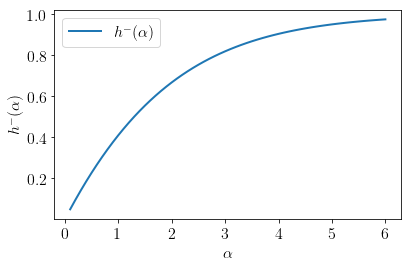

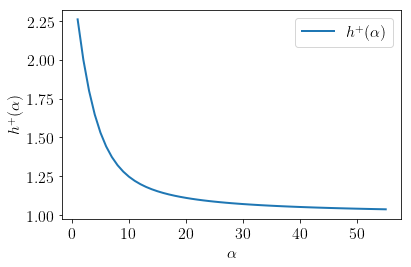

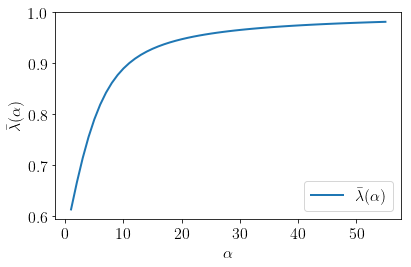

lambda_bar(1) = 0.6137056388801094 h^+(1) = 2.258891353270929
lambda_bar(2) = 0.6666666666666666 h^+(2) = 2.0
lambda_bar(3) = 0.7142857142857143 h^+(3) = 1.8
lambda_bar(4) = 0.7555555555555555 h^+(4) = 1.6470588235294117


In [21]:
def h_minus(alpha):
    if alpha==1:
        return math.log(2)/(1+math.log(2))
    else:
        return (alpha*(2**(alpha-1)-1))/(alpha*2**(alpha-1)-1)

def h_plus(alpha):
    if alpha==1:
        return math.log(2)/(1-math.log(2))
    else:
        return (alpha*(2**(alpha-1)-1))/((alpha-2)*2**(alpha-1)+1)

def lambda_bar(alpha):
    return 2/(1+h_plus(alpha))
    
alphas = [a/10 for a in range(1,61)]
hm = [h_minus(a) for a in alphas]

compare_lines(alphas, lines=[hm], x_label=r'$\alpha$', y_label=r'$h^-(\alpha)$',
              leg_labels=[r'$h^-(\alpha)$'],
              filename='h_minus_alpha')

alphas = [a for a in range(1,56)]
hp = [h_plus(a) for a in alphas]
lb = [lambda_bar(a) for a in alphas]

compare_lines(alphas, lines=[hp], x_label=r'$\alpha$', y_label=r'$h^+(\alpha)$',
              leg_labels=[r'$h^+(\alpha)$'],
              filename='h_plus_alpha')

compare_lines(alphas, lines=[lb], x_label=r'$\alpha$', y_label=r'$\bar{\lambda}(\alpha)$',
              leg_labels=[r'$\bar{\lambda}(\alpha)$'],
              filename='lambda_bar_alpha')

alphas = [1, 2, 3, 4]
for a in alphas:
    print('lambda_bar('+str(a)+') =', lambda_bar(a), 'h^+('+str(a)+') =', h_plus(a))

#### Analysis of $\Delta I^-_{\alpha}$

$$
\Delta I^-_{\alpha}(\lambda, \mu; n) < 0 \quad\Rightarrow\quad \mu<h^-(\alpha) \lambda \quad\textrm{where,}\quad
h^-(\alpha) =  \left\{
\begin{array}{ll}
\dfrac{\ln2}{1+\ln2} \approx 0.41 & \quad\textrm{for}\quad\alpha = 1 \\
\dfrac{\alpha(2^{\alpha-1}-1)}{\alpha2^{\alpha-1}-1}
& \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right\} < 1 \quad\forall\,\alpha>0.
$$

Recall we must have $\mu\geq\lambda$. Then for $\Delta I^-_{\alpha}<0$ we need $h^-(\alpha)>1$, which never happens.

#### Analysis of $\Delta I^+_{\alpha}$

$$
\Delta I^+_{\alpha}(\lambda, \mu; n) < 0 \quad\Rightarrow\quad \mu>h^+(\alpha) \lambda \quad\textrm{where,}\quad
h^+(\alpha) =  \left\{
\begin{array}{ll}
\dfrac{\ln2}{1-\ln2} \approx 2.26 & \quad\textrm{for}\quad\alpha = 1 \\
\dfrac{\alpha(2^{\alpha-1}-1)}{(\alpha-2)2^{\alpha-1}+1}
& \quad\textrm{for}\quad 0<\alpha\ne1
\end{array}\right.
$$

Recall we must have $\mu\leq2-\lambda$. Then for $\Delta I^+_{\alpha}<0$ we need,
$$
h^+(\alpha)\lambda < 2-\lambda \quad\Leftrightarrow\quad
\lambda < \bar{\lambda}(\alpha) = \frac{2}{1+h^+(\alpha)} < 1
$$
Since $\bar{\lambda}(\alpha)<1$ for all $\alpha>0$, we know that there are some circumstance under which a false positive error decreases the value of the index.

#### Draw the deviation region

The *deviation region* is the part of the domain for which the index is not reduced by reducing the error rate, it is reduced by increasing the error rate. We have shown that,
$$
I_{\alpha}(\lambda, \mu): ([0.5,1], [\lambda, 2-\lambda]) \mapsto \mathbb{R}_{\geq0}.
$$

The deviation region is then described as, $h^+(\alpha)\lambda<\mu<2-\lambda$ and we can draw it on a cartsian plane.

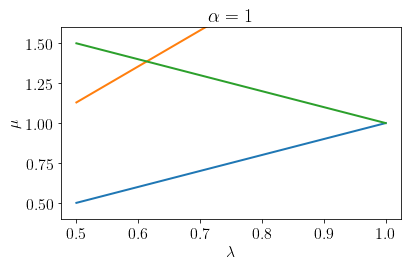

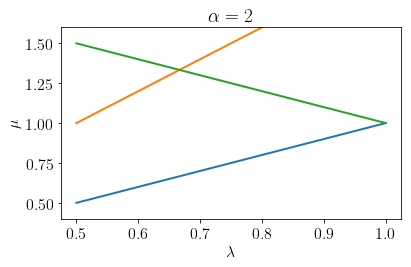

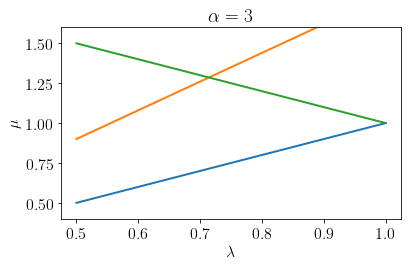

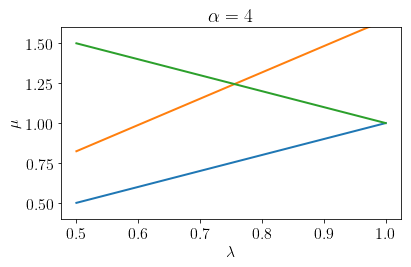

In [22]:
alphas = [i for i in range(1,5)]

lambdas = [i/100 for i in range(50,101)]
mu_low = lambdas
mu_high = [2-l for l in lambdas]

for i, a in enumerate(alphas):
    hp = h_plus(a)
    mu_dev = [l*hp for l in lambdas]
    compare_lines(lambdas, lines=[mu_low, mu_dev, mu_high],
                  x_label=r'$\lambda$', y_label=r'$\mu$',#legend=legends[j], 
                  leg_labels=['lower bound','deviation line', 'upper bound'], legend=False, leg_loc='upper right',
                  ylim=(0.4,1.6), title=r'$\alpha='+str(a)+'$', filename='DevReg'+'_alpha'+str(a))

#### Notes:

- As we increase $\alpha$, the deviation region becomes larger.
- We again reiterate that under this benefit function, only a false positive error is capable of reducing the index (not a false negative)
- What I need is a contour plot

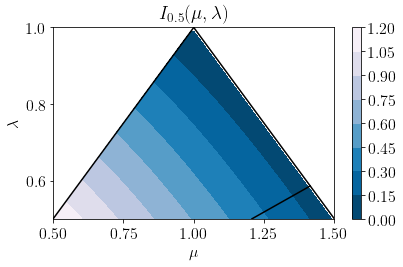

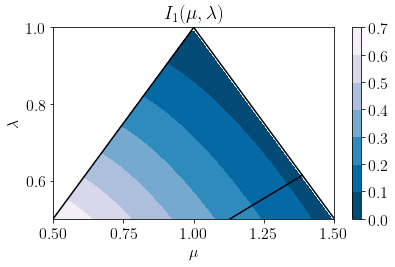

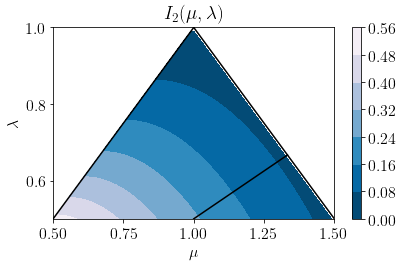

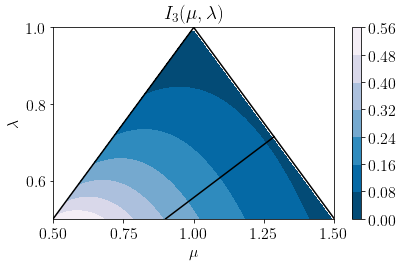

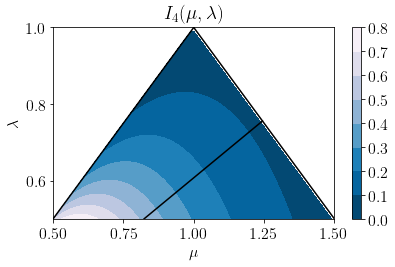

In [56]:
def contour_plot(xs, ys, zs, alpha, x_label, y_label,
                 colour=False, title=None, filename=None):
    """
    Plot training and test values as a function of x.
    """
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots()
    fname = 'cplot_'
    if colour:
        cs = ax.contourf(xs, ys, zs, cmap=cm.PuBu_r)
        cbar = fig.colorbar(cs)
        fname = 'ccplot_'
    else:
        cs = ax.contour(xs, ys, zs)#, cmap=cm.PuBu_r)
        ax.clabel(cs, inline=True, fontsize=10)
    
    plt.plot([0.5,1],[0.5,1],'-k')
    hp = h_plus(alpha)
    lb = lambda_bar(alpha)
    #plt.plot([0.5*hp,1.5],[0.5,1.5/hp],'-k')
    plt.plot([hp*0.5,hp*lb],[0.5,lb],'-k')
    plt.plot([1, 1.5],[1, 0.5],'-k')
    
    if title:
        ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.tight_layout()
    if filename:
        plt.savefig('05_figures_out/Fig_'+fname+filename+'.png', dpi=300)
    plt.show()
    
alphas  = [0.5]+[i for i in range(1,5)]
n       = 100
delta   = 1.0/n
mus     = np.arange(0.5, 1.5+delta, delta)
lambdas = np.arange(0.5, 1.0+delta, delta)
M, L    = np.meshgrid(mus, lambdas)

for a in alphas:
    I = I_alpha(L, M, a)
    I = ma.masked_where(M<L,   I)
    I = ma.masked_where(M>2-L, I)
    """
    contour_plot(M, L, I, a, x_label=r'$\mu$', y_label=r'$\lambda$', colour=False,
                 title=r'$I_{'+str(a)+'}(\mu,\lambda)$',
                 filename='alpha'+str(a))
    """
    contour_plot(M, L, I, a, x_label=r'$\mu$', y_label=r'$\lambda$', colour=True,
                  title=r'$I_{'+str(a)+'}(\mu,\lambda)$',
             filename='alpha'+str(a)) 

# Playground

In [24]:
print(math.log(2),2**0.5, 2*math.log(2))

0.6931471805599453 1.4142135623730951 1.3862943611198906


In [25]:
print(math.log(2)/(1+math.log(2)))
print(math.log(2)/(1-math.log(2)))

0.4093838908503587
2.258891353270929


In [26]:
print(ss.skew([0]*4+[1]*5+[2]*1))
print(ss.skew([0]*1+[1]*5+[2]*4))

0.365675149787956
-0.365675149787956


In [27]:
print([i for i in range(1, 5)])
print([0]*4)
print([0]*1+[1]*2)

[1, 2, 3, 4]
[0, 0, 0, 0]
[0, 1, 1]


In [28]:
x = [1,2,3]
y = [0,1,2]
X, Y = np.meshgrid(x,y)
print(X)
print(Y)
#X=ma.masked_where(Y < 2, X)
#print(X)
X[0]=ma.masked_where(Y[0] < 2, X[0])
print(X)

[[1 2 3]
 [1 2 3]
 [1 2 3]]
[[0 0 0]
 [1 1 1]
 [2 2 2]]
[[1 2 3]
 [1 2 3]
 [1 2 3]]


In [29]:
X[0]=X[0]-1
print(X)

[[0 1 2]
 [1 2 3]
 [1 2 3]]


In [30]:
a = np.arange(4)
print(a)
a=ma.masked_where(a <= 2, a)
print(a)


[0 1 2 3]
[-- -- -- 3]
